In [1]:
import time 
start_time = time.time()

import evaluate # self-written
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn import tree, metrics, ensemble, model_selection
from xgboost import plot_importance
from xgboost.sklearn import XGBClassifier
from tensorflow import keras

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set_theme(style="darkgrid")

In [2]:
data = pd.read_csv('data/data_after_LDA.csv')

num_features = data.shape[1] - 1
num_classes = 2

In [3]:
data.dtypes

topic_0            float64
topic_1            float64
topic_2            float64
topic_3            float64
topic_4            float64
nlikes             float64
nreplies           float64
nretweets          float64
tweets             float64
following          float64
followers          float64
likes              float64
media              float64
day                float64
reply_to           float64
url                float64
join_time          float64
day_after          float64
tweet_length       float64
tweet_sentiment    float64
bio_sentiment      float64
first_person       float64
second_person      float64
third_person       float64
label                int64
dtype: object

In [4]:
x, y = data.iloc[:,:-1], data.iloc[:,-1]
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.2, random_state = 1016)

# Single Decision Tree

Optimal max_tree_depth and it's mean cross validation score(AUC):  5 0.813849432759913


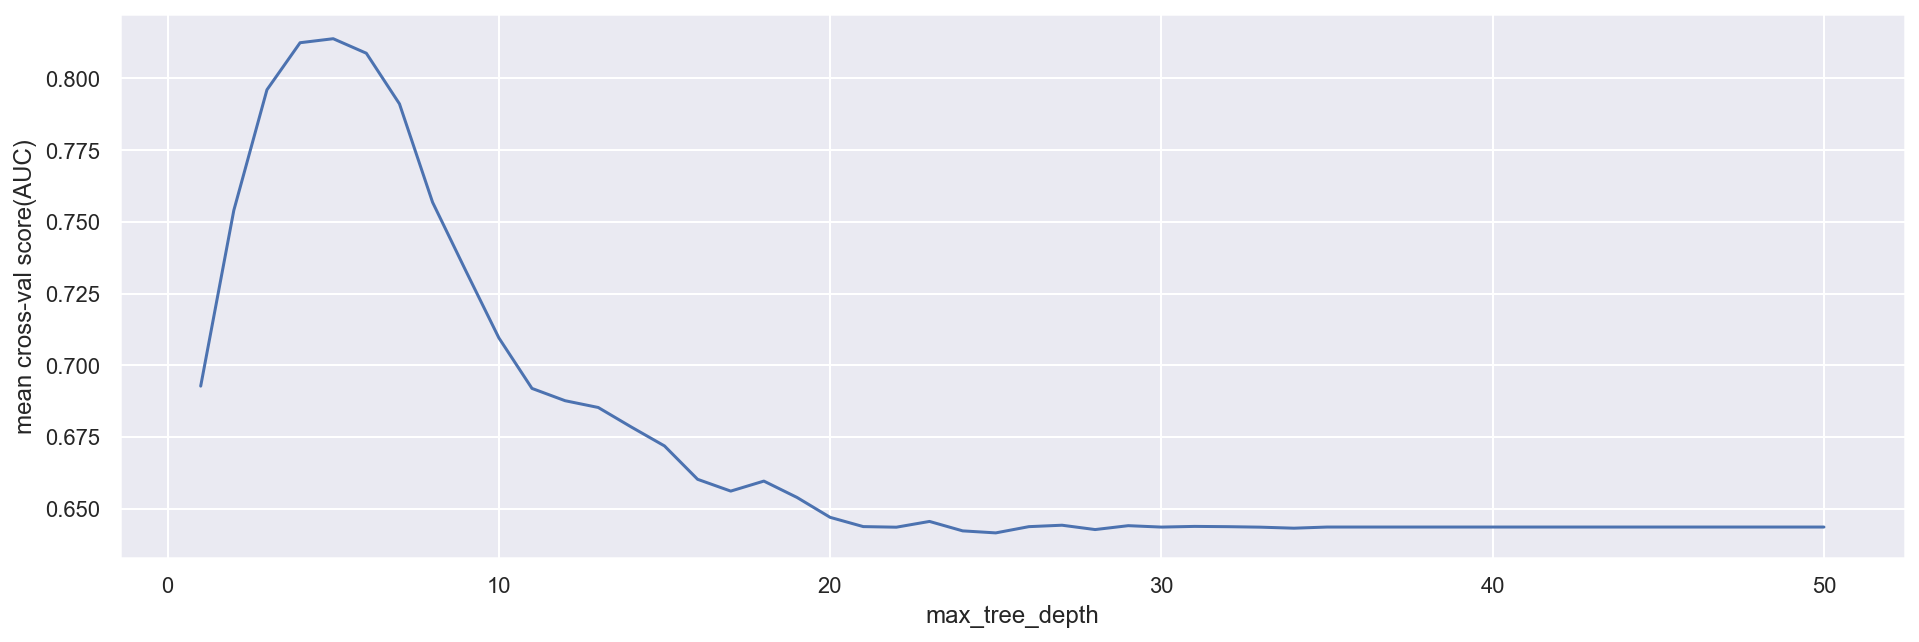

In [5]:
cv_score = []
num_CV = 50

for i in range(num_CV):
    dt_clf = tree.DecisionTreeClassifier(max_depth = i + 1, random_state = 1016, class_weight = 'balanced')
    score = model_selection.cross_val_score(dt_clf, x_train, y_train, scoring = "roc_auc", cv = 10).mean()
    cv_score.append(score)
cv_score = np.array(cv_score)

optimal_depth = (np.argmax(cv_score) + 1)
print("Optimal max_tree_depth and it's mean cross validation score(AUC): ", optimal_depth, cv_score[np.argmax(cv_score)])

plt.figure(figsize=(16,5))
sns.lineplot(data = pd.DataFrame({
    'max_tree_depth': range(1, num_CV + 1),
    'mean cross-val score(AUC)': cv_score
    }), x = "max_tree_depth", y = 'mean cross-val score(AUC)',
)
plt.show()

Optimal min_samples_split and it's mean cross validation score(AUC):  2 0.813849432759913
Optimal min_samples_leaf and it's mean cross validation score(AUC):  10 0.8160021737835745


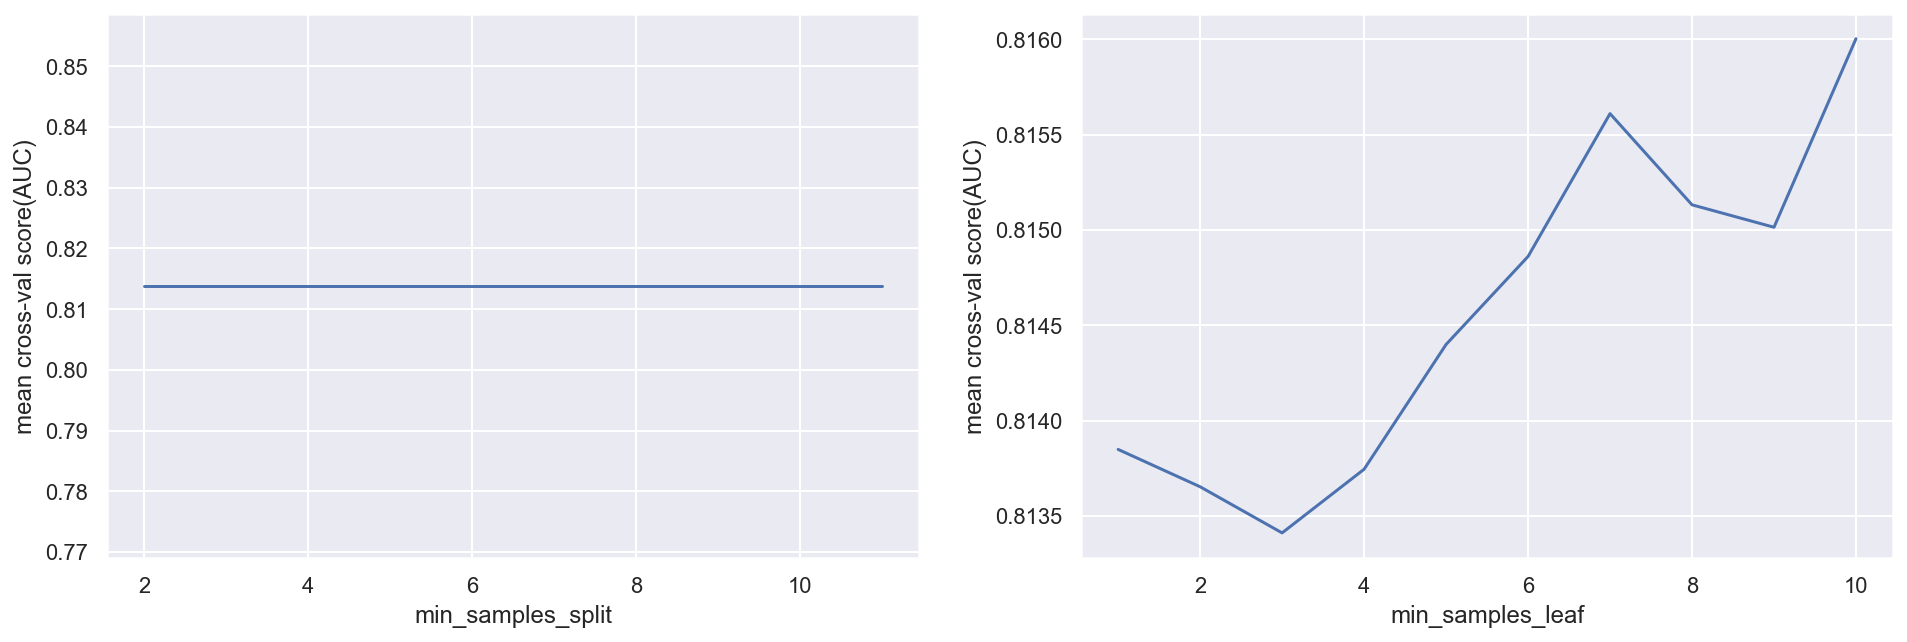

In [6]:
plt.figure(figsize = [16,5])
cv_score = []
num_CV = 10

# Tuning min_samples_split
for i in range(num_CV):
    dt_clf = tree.DecisionTreeClassifier(
        max_depth = optimal_depth, 
        min_samples_split = i + 2, 
        random_state = 1016, 
        class_weight = 'balanced'
    )
    score = model_selection.cross_val_score(dt_clf, x_train, y_train, scoring = "roc_auc", cv = 10).mean()
    cv_score.append(score)
cv_score = np.array(cv_score)

optimal_split = np.argmax(cv_score) + 2
print("Optimal min_samples_split and it's mean cross validation score(AUC): ", optimal_split, cv_score[np.argmax(cv_score)])  

plt.subplot(1, 2, 1)
sns.lineplot(data = pd.DataFrame({
    'min_samples_split': range(2, num_CV + 2),
    'mean cross-val score(AUC)': cv_score
    }), x = "min_samples_split", y = 'mean cross-val score(AUC)',
)

cv_score = []
# Tuning min_samples_leaf
for i in range(num_CV):
    dt_clf = tree.DecisionTreeClassifier(
        max_depth = optimal_depth, 
        min_samples_split = optimal_split, 
        min_samples_leaf = i + 1,
        random_state = 1016, 
        class_weight = 'balanced'
    )
    score = model_selection.cross_val_score(dt_clf, x_train, y_train, scoring = "roc_auc", cv = 10).mean()
    cv_score.append(score)
cv_score = np.array(cv_score)

optimal_leaf = np.argmax(cv_score) + 1
print("Optimal min_samples_leaf and it's mean cross validation score(AUC): ", optimal_leaf, cv_score[np.argmax(cv_score)])  
plt.subplot(1, 2, 2)
sns.lineplot(data = pd.DataFrame({
    'min_samples_leaf': range(1, num_CV + 1),
    'mean cross-val score(AUC)': cv_score
    }), x = "min_samples_leaf", y = 'mean cross-val score(AUC)',
)

plt.show()

In [7]:
param_grid = {
    'max_depth': np.arange(1, 10),
    'min_samples_leaf': np.arange(1, 10),
}

dt_clf = tree.DecisionTreeClassifier(random_state = 1016, class_weight = 'balanced')
GS = model_selection.GridSearchCV(dt_clf, param_grid, scoring = 'roc_auc', n_jobs = -1, cv = 10)
GS.fit(x_train, y_train) 

for k, v in GS.best_params_.items():
    print("Optimal {} = {}".format(k, v))

print("Best model's AUC score: {}".format(GS.best_score_))

Optimal max_depth = 6
Optimal min_samples_leaf = 9
Best model's AUC score: 0.8159113632583942


In [8]:
dt_clf = GS.best_estimator_
y_pred_proba = dt_clf.predict_proba(x_test)

y_pred = evaluate.threshold(y_pred_proba, y_test)['y_pred']
print(evaluate.performance(y_test, y_pred, y_pred_proba)['report'])


The evaluation report of classification is:
Confusion Matrix:
[[800 622]
 [ 43 383]]
Accuracy: 0.6401515151515151
Precision: 0.38109452736318405
Recall: 0.8990610328638498
F2 Score: 0.7069029162052417
AUC Score: 0.8156418586530906



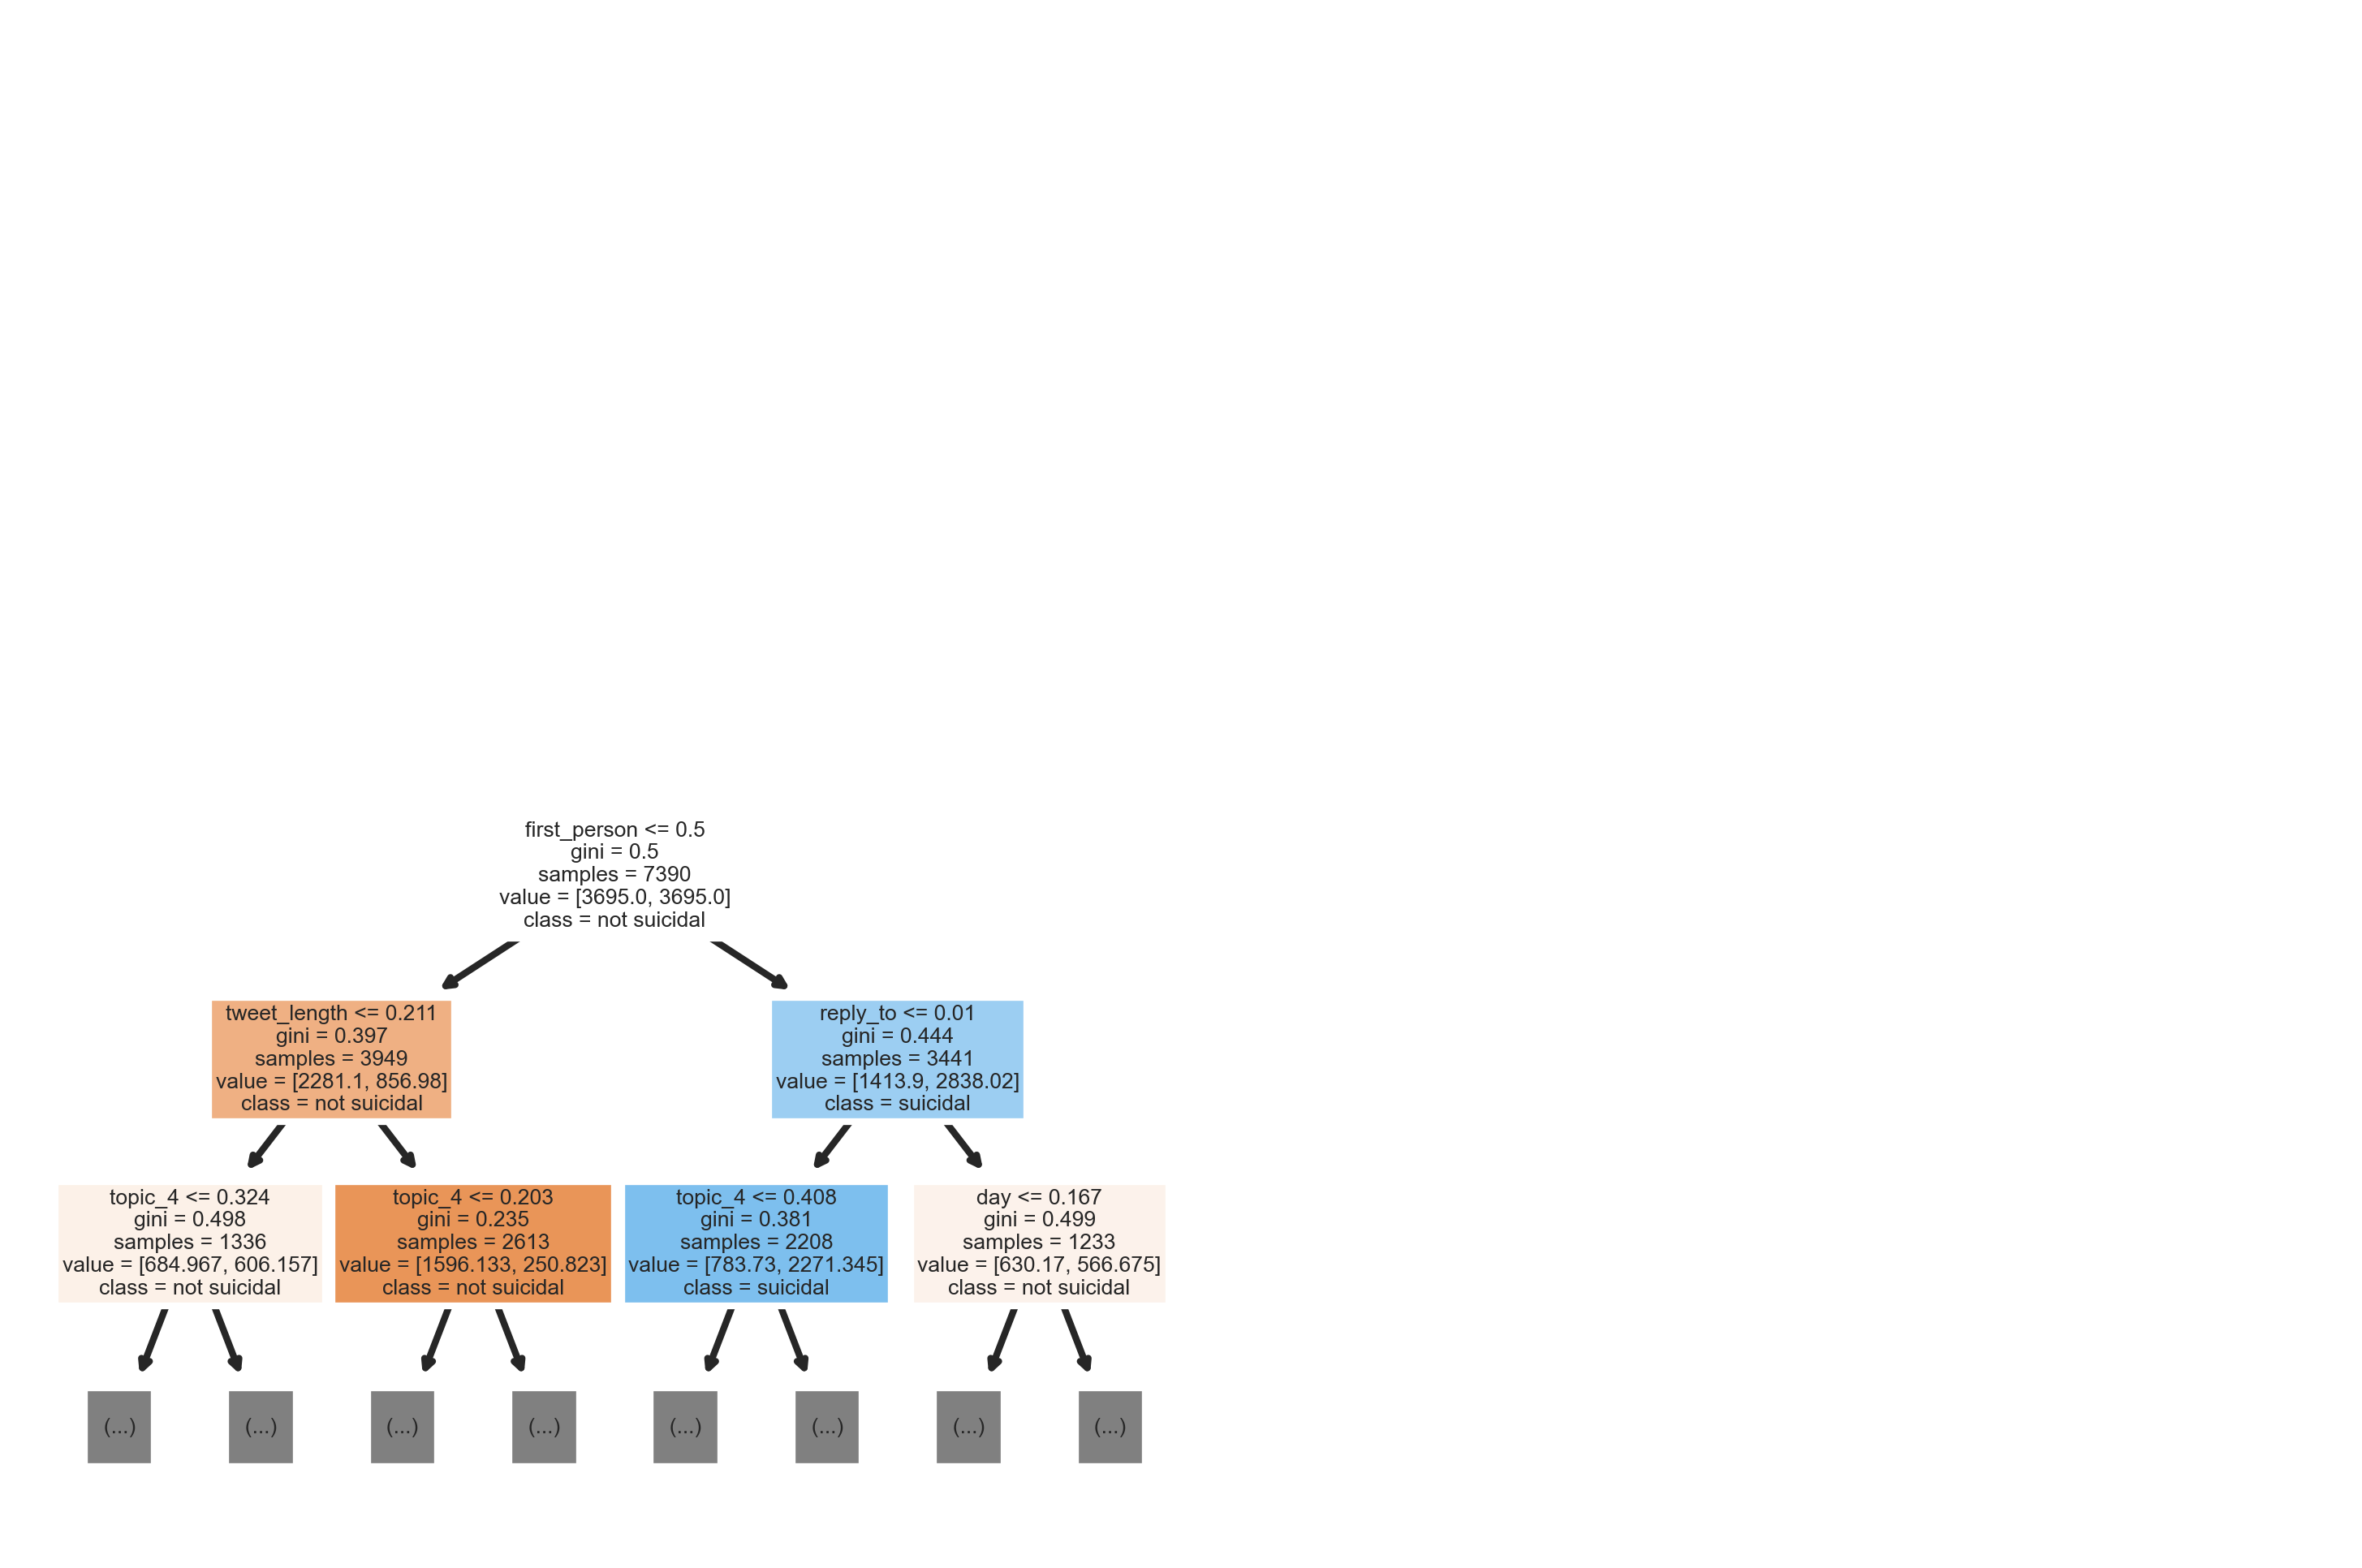

In [9]:
fig = plt.figure(dpi = 300)
tree.plot_tree(
    dt_clf, 
    max_depth = 2,
    feature_names = data.columns,  
    class_names = ['not suicidal', 'suicidal'],
    filled = True
)
fig.savefig("decistion_tree.png")

# XGBoost

In [10]:
param_grid = {
    'max_depth':[3, 5, 7, 9],
    'min_child_weight':[1, 3, 5],
}

GS = model_selection.GridSearchCV(
    estimator = XGBClassifier(use_label_encoder = False),
    param_grid = param_grid,
    n_jobs = -1,
    cv = 5,
    scoring = 'roc_auc',
    verbose = 4
)

GS.fit(x_train, y_train)
for k, v in GS.best_params_.items():
    print("Optimal {} = {}".format(k, v))

print("Best model's AUC score: {}".format(GS.best_score_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[20:50:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Optimal max_depth = 3
Optimal min_child_weight = 5
Best model's AUC score: 0.8620418073961907


In [11]:
param_grid = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'n_estimators': range(100, 1001, 100),
}
GS = model_selection.GridSearchCV(
    estimator = XGBClassifier(max_depth = 3, min_child_weight = 5, use_label_encoder = False),
    param_grid = param_grid,
    n_jobs = -1,
    cv = 5,
    scoring = 'roc_auc',
    verbose = 4
)

GS.fit(x_train, y_train)
for k, v in GS.best_params_.items():
    print("Optimal {} = {}".format(k, v))

print("Best model's AUC score: {}".format(GS.best_score_))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[20:55:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Optimal learning_rate = 0.05
Optimal n_estimators = 300
Best model's AUC score: 0.8665038460753995


In [12]:
xgb_clf = XGBClassifier(n_estimators = 300, max_depth = 3, min_child_weight = 5, learning_rate = 0.05, use_label_encoder = False)
xgb_clf.fit(x_train, y_train)
y_pred_proba = xgb_clf.predict_proba(x_test)
y_pred = evaluate.threshold(y_pred_proba, y_test)['y_pred']
print(evaluate.performance(y_test, y_pred, y_pred_proba)['report'])

[20:55:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

The evaluation report of classification is:
Confusion Matrix:
[[1092  330]
 [  55  371]]
Accuracy: 0.7916666666666666
Precision: 0.5292439372325249
Recall: 0.8708920187793427
F2 Score: 0.7713097713097713
AUC Score: 0.8805672761368963



<Figure size 1800x1200 with 0 Axes>

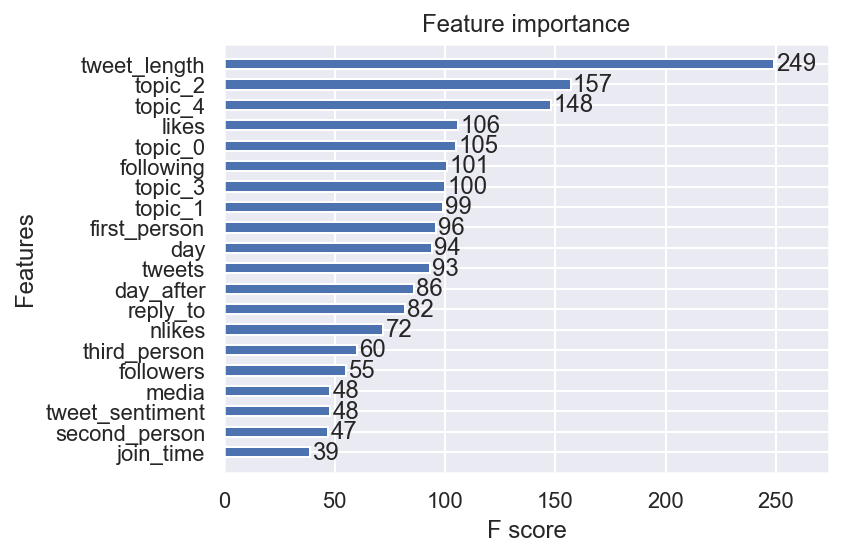

In [13]:
fig = plt.figure(dpi = 300)
ax = plot_importance(xgb_clf, max_num_features=20, height=0.5)
ax.figure.tight_layout()
ax.figure.savefig("xgboost_feature.png")

# Neural Network (Fully Connected)

In [14]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]
    
model = keras.Sequential([
    keras.layers.Input(shape = (24, )),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
    metrics = METRICS
)

In [15]:
total = len(data)
pos = np.count_nonzero(data.iloc[:,-1])
neg = total - pos

weight_for_0 = (1 / neg) * (total) / 2.0 
weight_for_1 = (1 / pos) * (total) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.64
Weight for class 1: 2.29


In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_auc', 
    verbose = 1,
    patience = 10,
    mode = 'max',
    restore_best_weights = True
)

history = model.fit(
    x = x_train, y = y_train,
    batch_size = 256,
    validation_split = 0.2,
    epochs = 100,
    callbacks = [early_stopping],
    class_weight = class_weight,
    verbose = 0
)

Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping


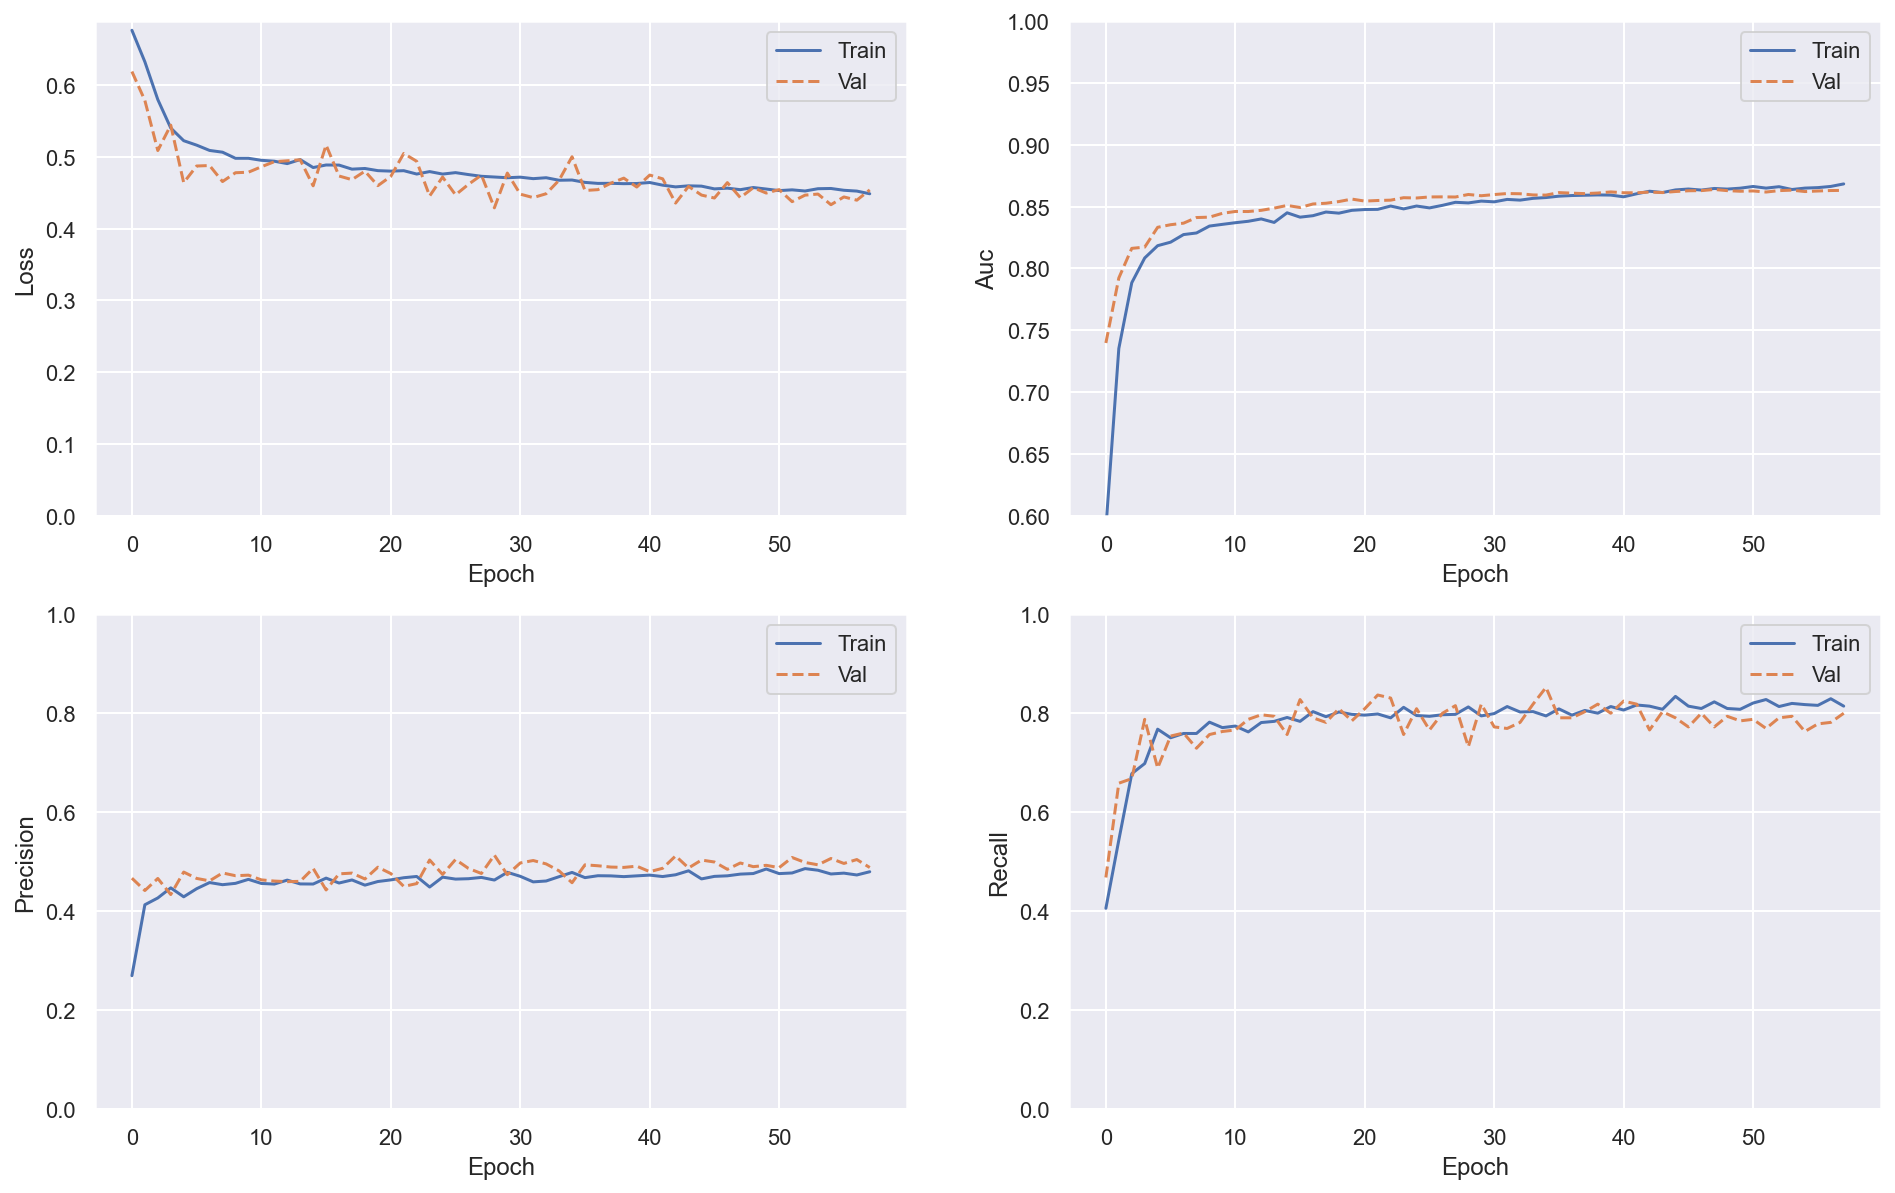

In [17]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
metrics = ['loss', 'auc', 'precision', 'recall']

plt.figure(figsize=(16, 10))
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2, 2, n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color=colors[1], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
        plt.ylim([0.6,1])
    else:
        plt.ylim([0,1])
    plt.legend()

In [18]:
y_pred_proba = model.predict(x_test)
y_pred_proba = np.hstack((y_pred_proba, y_pred_proba))

y_pred = evaluate.threshold(y_pred_proba, y_test)['y_pred']
print(evaluate.performance(y_test, y_pred, y_pred_proba)['report'])


The evaluation report of classification is:
Confusion Matrix:
[[971 451]
 [ 44 382]]
Accuracy: 0.7321428571428571
Precision: 0.45858343337334934
Recall: 0.8967136150234741
F2 Score: 0.7528577059519116
AUC Score: 0.868650251249645



In [19]:
end_time = time.time()

print("Time: {0:.2f}s".format(end_time - start_time))

Time: 382.58s
